# Testing Water Detection in Multiple Resolutions

The `WaterFinder` can detect water in full S1-RTC resolution as well as in given shapes. This notebook will test this behavior for both S1 and GFM detection.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shapely import box
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from flood_finder.floodprocessor import FloodProcessor
from flood_finder.reporter import ProcessorReporter
from flood_finder.waterfinder import WaterFinder
from flood_finder.imagery import ImageFinder
from owslib.wms import WebMapService


## Define the ROI

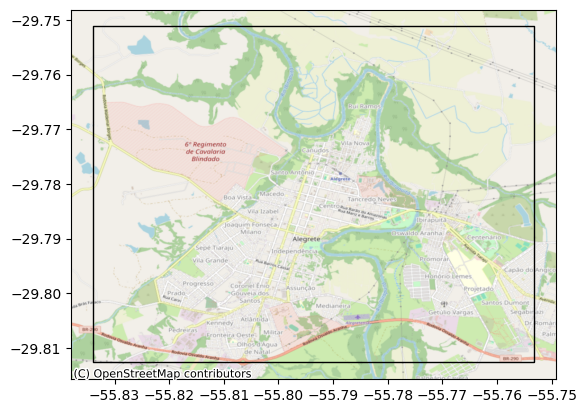

In [3]:
# Anavilhanas area
bbox = (-55.833918389468636,  -29.81268477102558, -55.75315601911373,  -29.75118793843714)

gdf = gpd.GeoDataFrame(geometry=[box(*bbox)])
ax = gdf.plot(facecolor='none')
cx.add_basemap(ax=ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)

## Create a `ImageFinder` instance

In [4]:
# read the subscription key
with open('../subscription.key', 'r') as file:
    subscription_key = file.read()

In [5]:
finder = ImageFinder(subscription_key=subscription_key)
s1imagery = finder.get_s1_images(
    aoi=box(*bbox),
    time_range='2019-01-01/2019-01-31',
    lee_size=None,
    group_items=False,
    shape=None
)

In [6]:
s1imagery.dates

array(['2019-01-06', '2019-01-15', '2019-01-18', '2019-01-30'],
      dtype=object)

In [7]:
s1imagery.shape

(680, 790)

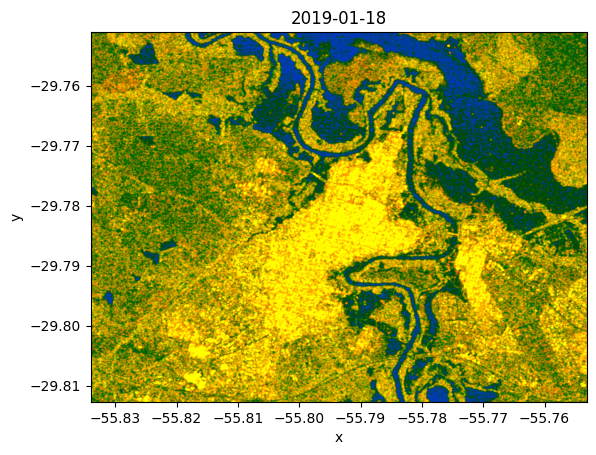

In [8]:
s1imagery.plot_date('2019-01-18', raw=True)

## Create a `WaterFinder` instance

In [9]:
waterfinder = WaterFinder(
    output_path='../tmp',
    aoi=box(*bbox),
    subscription_key=subscription_key,
    time_range='2019-01-01/2019-01-31',
    print_log=True,
    group_items=False, 
    shape=None
)

waterfinder

2024-03-07 18:48:06 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp


2024-03-07 18:48:06 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI


WaterFinder for place tmp
Available dates: 4
Water detected dates: 0

In [10]:
waterfinder.find_water('../model/RF_Model_v2.joblib', use_gfm=False, resume=False)

  0%|          | 0/4 [00:00<?, ?it/s]

2024-03-07 18:48:07 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-01-06
2024-03-07 18:48:18 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-01-15
2024-03-07 18:48:28 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-01-18
2024-03-07 18:48:38 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-01-30
2024-03-07 18:48:48 | tmp.WaterFinder:INFO -> Saving waters.nc. i=3


In [11]:
waterfinder.waters

<xarray.Dataset>
Dimensions:     (x: 790, y: 680)
Coordinates:
  * x           (x) float64 -55.83 -55.83 -55.83 -55.83 ... -55.75 -55.75 -55.75
  * y           (y) float64 -29.75 -29.75 -29.75 -29.75 ... -29.81 -29.81 -29.81
    epsg        int64 4326
Data variables:
    2019-01-06  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-01-15  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-01-18  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-01-30  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

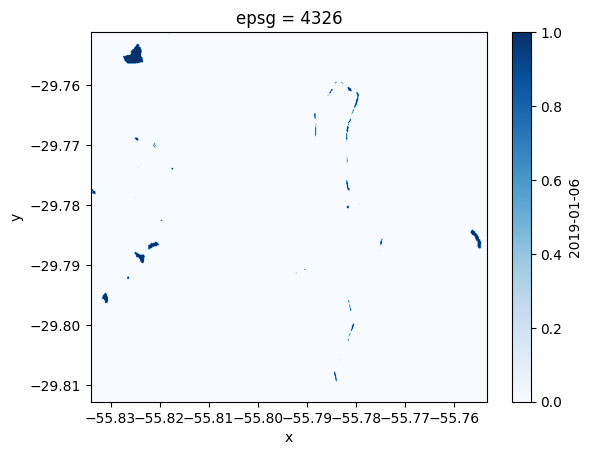

In [74]:
waterfinder.waters['2019-01-06'].plot.imshow(cmap='Blues', interpolation='bilinear')

In [13]:
waterfinder.s1imagery['2019-01-06'].shape

(2, 680, 790)

## GFM Tests

Now, let's use GFM to deliver the same masks

In [76]:
waterfinder.find_water(use_gfm=True, resume=False)

  0%|          | 0/4 [00:00<?, ?it/s]

2024-03-04 19:10:02 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2019-01-06
2024-03-04 19:10:04 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2019-01-15
2024-03-04 19:10:06 | tmp.WaterFinder:WARNING -> No data for date 2019-01-15.
2024-03-04 19:10:06 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2019-01-18
2024-03-04 19:10:08 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2019-01-30
2024-03-04 19:10:10 | tmp.WaterFinder:INFO -> Saving waters.nc. i=3


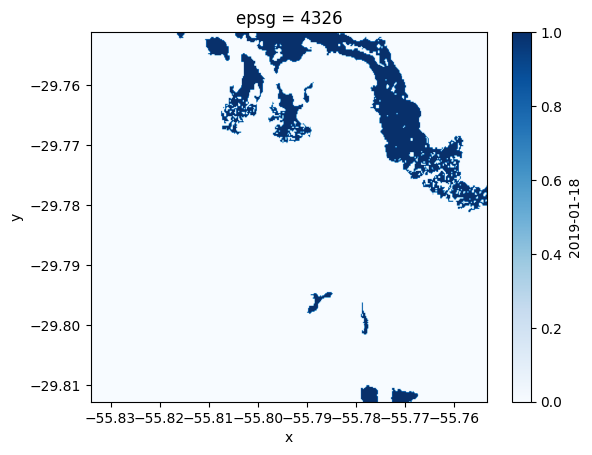

In [78]:
waterfinder.waters['2019-01-18'].plot.imshow(cmap='Blues', interpolation='bilinear')

## Testing the Resume

In [80]:
waterfinder = WaterFinder(
    output_path='../tmp',
    aoi=box(*bbox),
    subscription_key=subscription_key,
    time_range='2019-01-01/2019-02-28',
    print_log=True,
    group_items=False
)

waterfinder

2024-03-04 19:28:02 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp


2024-03-04 19:28:03 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI


WaterFinder for place tmp
Available dates: 6
Water detected dates: 0

In [82]:
waterfinder.find_water(model_path='../model/RF_Model_v2.joblib', use_gfm=False, resume=True)

2024-03-04 19:28:31 | tmp.WaterFinder:INFO -> Resuming from previous waters.nc file


2024-03-04 19:28:31 | tmp.WaterFinder:INFO -> Resuming from date 2019-01-30


  0%|          | 0/2 [00:00<?, ?it/s]

2024-03-04 19:28:32 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-02-11
2024-03-04 19:28:45 | tmp.WaterFinder:INFO -> Seeking for water in date: 2019-02-23
2024-03-04 19:28:57 | tmp.WaterFinder:INFO -> Saving waters.nc. i=1


In [83]:
waterfinder.waters

<xarray.Dataset>
Dimensions:     (x: 790, y: 680)
Coordinates:
  * x           (x) float64 -55.83 -55.83 -55.83 -55.83 ... -55.75 -55.75 -55.75
  * y           (y) float64 -29.75 -29.75 -29.75 -29.75 ... -29.81 -29.81 -29.81
    epsg        int64 4326
Data variables:
    2019-01-06  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-01-18  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-01-30  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-02-11  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2019-02-23  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

## Testing the `FloodProcessor`

In [116]:
import geopandas as gpd
processor = FloodProcessor(
    aoi_df = gpd.GeoDataFrame(geometry=[box(*bbox)]),
    output_dir='../tmp',
    subscription_key=subscription_key,
    time_range='2019-01-01/2019-02-28',
    print_log=True,
)

2024-03-04 19:44:56 | tmp.FloodProcessor:INFO -> Creating processor for place: tmp
2024-03-04 19:44:56 | tmp.FloodProcessor:INFO -> Saving file ../tmp/gdf.geojson
2024-03-04 19:44:57 | tmp.FloodProcessor:INFO -> Retrieving water recurrence
2024-03-04 19:44:58 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp
2024-03-04 19:44:59 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI
2024-03-04 19:44:59 | tmp.FloodProcessor:INFO -> Saving variables locally


In [117]:
processor.find_water()

2024-03-04 19:45:01 | tmp.FloodProcessor:INFO -> Creating a water extents series
2024-03-04 19:45:01 | tmp.WaterFinder:INFO -> Resuming from previous waters.nc file
2024-03-04 19:45:01 | tmp.WaterFinder:INFO -> Resuming from date 2019-02-23


No date left to process. Check self.waters


In [119]:
processor.process_floods()

2024-03-04 19:46:21 | tmp.FloodProcessor:INFO -> Calculating flood area for each date


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-04 19:46:21 | tmp.FloodProcessor:INFO -> table.csv exported with water/flood series


In [115]:
str(processor['waters']['2019-01-06'].coords['epsg'].data)

'4326'

In [121]:
processor

Flood Processor for place: tmp
Variables: ['aoi_df', 'recurrence', 'waters', 'water_series', 'data_table', 'floods', 'max_flood']
WaterFinder for place tmp
Available dates: 6
Water detected dates: 5

In [123]:
processor['data_table']

,Water Extents,Flood area
2019-01-06,0.0000,0.0000
2019-01-18,39.5631,4.7475
2019-01-30,0.0000,0.0000
2019-02-11,7.0452,0.7200
2019-02-23,7.8795,0.8244
